In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def extract_landmarks(video_path, num_frames=30):
    """
    Extracts pose landmarks from a video file, padded or truncated to a fixed number of frames.
    """
    cap = cv2.VideoCapture(video_path)
    landmarks_list = []
    frame_count = 0  # Frame counter for tracking extracted frames
    
    while cap.isOpened() and len(landmarks_list) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert the frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Process the frame to extract pose landmarks
        results = pose.process(frame_rgb)
        
        if results.pose_landmarks:
            # Flatten the landmarks to a 1D array
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
            landmarks_list.append(landmarks)
        
        frame_count += 1  # Increment frame counter
    
    cap.release()
    
    # Print the frame count for this video
    print(f"Total frames extracted from {video_path}: {frame_count}")
    
    # Padding with zeros if the video has less than num_frames frames
    while len(landmarks_list) < num_frames:
        landmarks_list.append(np.zeros(len(landmarks_list[0])))  # Add zeros of same shape
    
    # Convert to numpy array and truncate to num_frames if it exceeds
    return np.array(landmarks_list[:num_frames])

def prepare_dataset(root_folder, num_frames=30):
    """
    Prepares the dataset by extracting landmarks from videos in 'correct' and 'incorrect' subfolders.
    """
    # Define paths for correct and incorrect folders
    correct_folder = os.path.join(root_folder, 'correct')
    incorrect_folder = os.path.join(root_folder, 'incorrect')
    
    data = []
    labels = []
    
    # Check if both subfolders exist
    if not os.path.isdir(correct_folder) or not os.path.isdir(incorrect_folder):
        print("Error: 'correct' or 'incorrect' folder not found.")
        return None, None
    
    # Process videos in the 'correct' folder
    for file in os.listdir(correct_folder):
        if file.endswith('.mp4'):
            video_path = os.path.join(correct_folder, file)
            landmarks = extract_landmarks(video_path, num_frames=num_frames)
            if landmarks.size > 0:
                data.append(landmarks)
                labels.append(1)  # Label '1' for correct form
    
    # Process videos in the 'incorrect' folder
    for file in os.listdir(incorrect_folder):
        if file.endswith('.mp4'):
            video_path = os.path.join(incorrect_folder, file)
            landmarks = extract_landmarks(video_path, num_frames=num_frames)
            if landmarks.size > 0:
                data.append(landmarks)
                labels.append(0)  # Label '0' for incorrect form
    
    return np.array(data), np.array(labels)

# Example usage
root_folder = './OneDrive/Desktop/camdataset'  # Replace with the path to your dataset's root folder
data, labels = prepare_dataset(root_folder, num_frames=30)

# Check the shape of data and labels to verify
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


C:\Users\sthel\AppData\Roaming\Python\Python311\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Total frames extracted from ./OneDrive/Desktop/camdataset\correct\WhatsApp Video 2024-11-07 at 23.33.26_8a320cdb.mp4: 30
Total frames extracted from ./OneDrive/Desktop/camdataset\correct\WhatsApp Video 2024-11-07 at 23.33.28_0d877282.mp4: 30
Total frames extracted from ./OneDrive/Desktop/camdataset\correct\WhatsApp Video 2024-11-07 at 23.33.28_1d2820b5.mp4: 30
Total frames extracted from ./OneDrive/Desktop/camdataset\correct\WhatsApp Video 2024-11-07 at 23.33.30_b8dace39.mp4: 30
Total frames extracted from ./OneDrive/Desktop/camdataset\correct\WhatsApp Video 2024-11-07 at 23.33.33_ff2662d8.mp4: 30
Total frames extracted from ./OneDrive/Desktop/camdataset\correct\WhatsApp Video 2024-11-07 at 23.33.34_d48dad48.mp4: 30
Total frames extracted from ./OneDrive/Desktop/camdataset\correct\WhatsApp Video 2024-11-07 at 23.33.36_2e6da658.mp4: 30
Total frames extracted from ./OneDrive/Desktop/camdataset\correct\WhatsApp Video 2024-11-07 at 23.33.37_0b6a979a.mp4: 30
Total frames extracted from ./On

In [2]:
from sklearn.model_selection import train_test_split

# Reshape data if needed (depends on the model; for example, LSTM may need 3D input shape)
X = data  # Landmarks
y = labels  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Adjusted dropout
model.add(LSTM(32))
model.add(Dropout(0.3))  # Adjusted dropout
model.add(Dense(32, activation='relu'))  # Additional dense layer for improved learning
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification (correct/incorrect)

# Compile model with gradient clipping
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


C:\Users\sthel\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.3731 - loss: 0.7137 - val_accuracy: 0.5909 - val_loss: 0.6621
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6306 - loss: 0.6573 - val_accuracy: 0.5909 - val_loss: 0.6380
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6234 - loss: 0.6470 - val_accuracy: 0.5909 - val_loss: 0.6126
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6973 - loss: 0.6064 - val_accuracy: 0.6364 - val_loss: 0.5727
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6987 - loss: 0.6186 - val_accuracy: 0.7273 - val_loss: 0.5888
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7504 - loss: 0.5616 - val_accuracy: 0.6818 - val_loss: 0.5568
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6844 - loss: 0.5709 - val_accuracy: 0.7273 - val_loss: 0.4656
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7794 - loss: 0.4761 - val_accuracy: 0.8636 - val_loss: 0.4282

In [4]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9091 - loss: 0.2919
Test Accuracy: 90.91%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


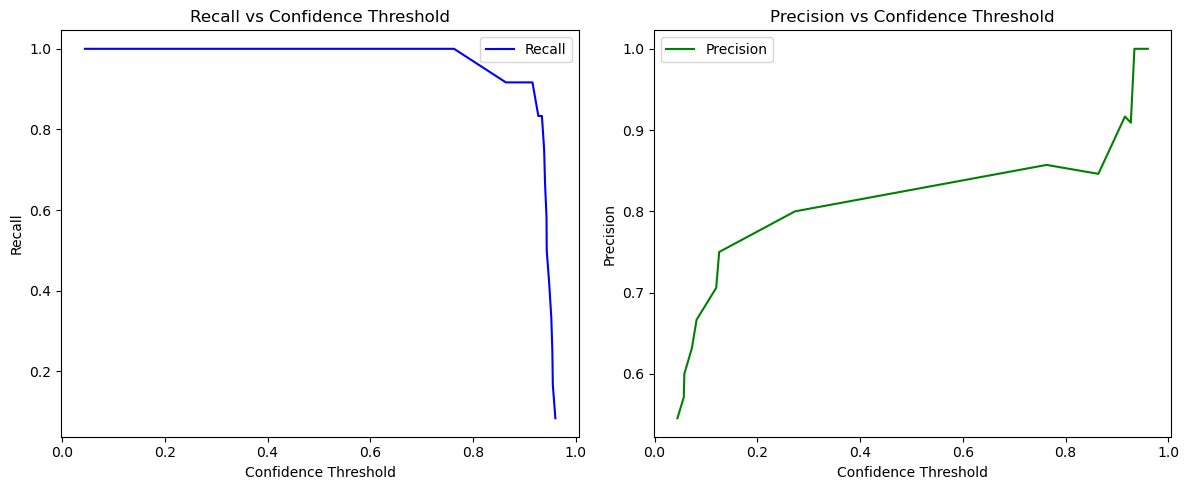

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Step 1: Get the prediction probabilities on the test set
y_prob = model.predict(X_test)  # Predicted probabilities
y_true = y_test  # True labels

# Step 2: Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

# Step 3: Plot the Recall-Confidence and Precision-Confidence curves
plt.figure(figsize=(12, 5))

# Recall-Confidence Curve
plt.subplot(1, 2, 1)
plt.plot(thresholds, recall[:-1], label="Recall", color="blue")
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Confidence Threshold")
plt.legend()

# Precision-Confidence Curve
plt.subplot(1, 2, 2)
plt.plot(thresholds, precision[:-1], label="Precision", color="green")
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Confidence Threshold")
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


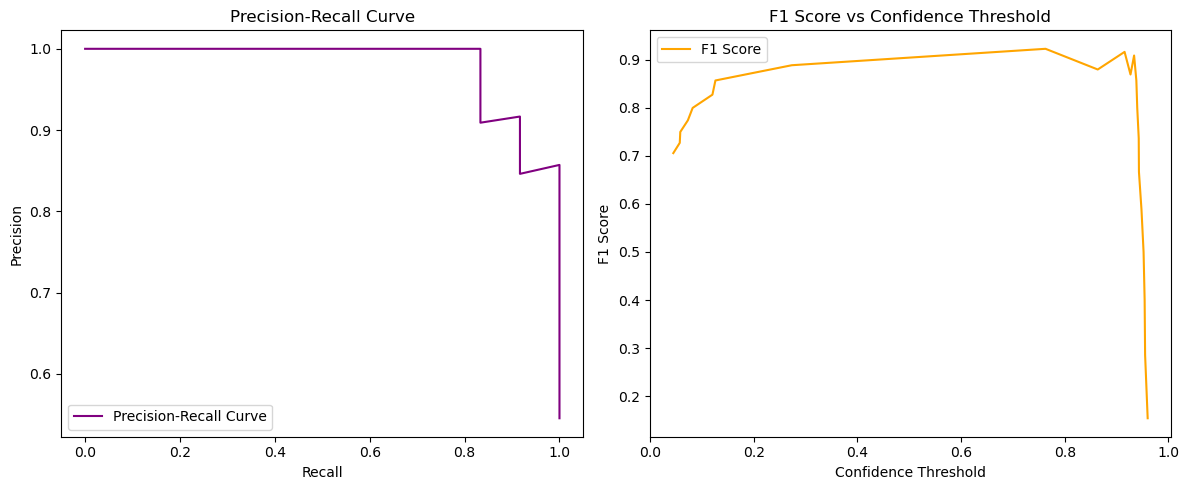

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Step 1: Get prediction probabilities on the test set
y_prob = model.predict(X_test)  # Model's prediction probabilities
y_true = y_test  # True labels

# Step 2: Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

# Step 3: Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)  # Small epsilon to avoid division by zero

# Step 4: Plot the Precision-Recall Curve and F1-Confidence Curve
plt.figure(figsize=(12, 5))

# Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label="Precision-Recall Curve", color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# F1-Confidence Curve
plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="orange")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Confidence Threshold")
plt.legend()

plt.tight_layout()
plt.show()


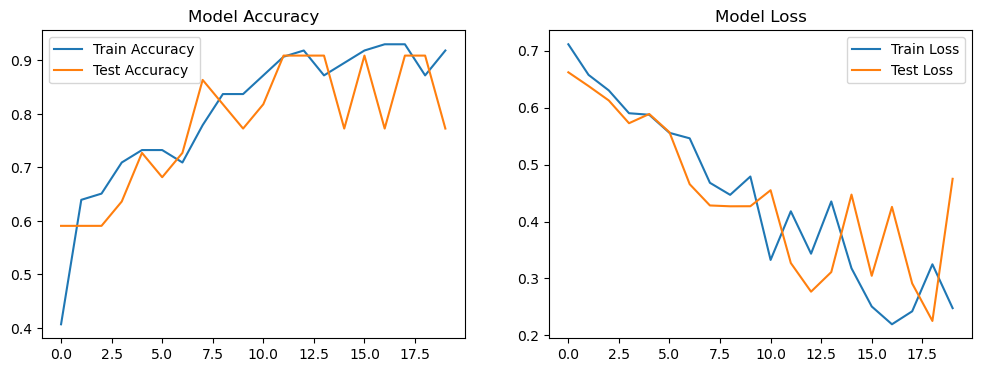

In [7]:
import matplotlib.pyplot as plt

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel("Confidence Threshold")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Model Loss')

plt.show()


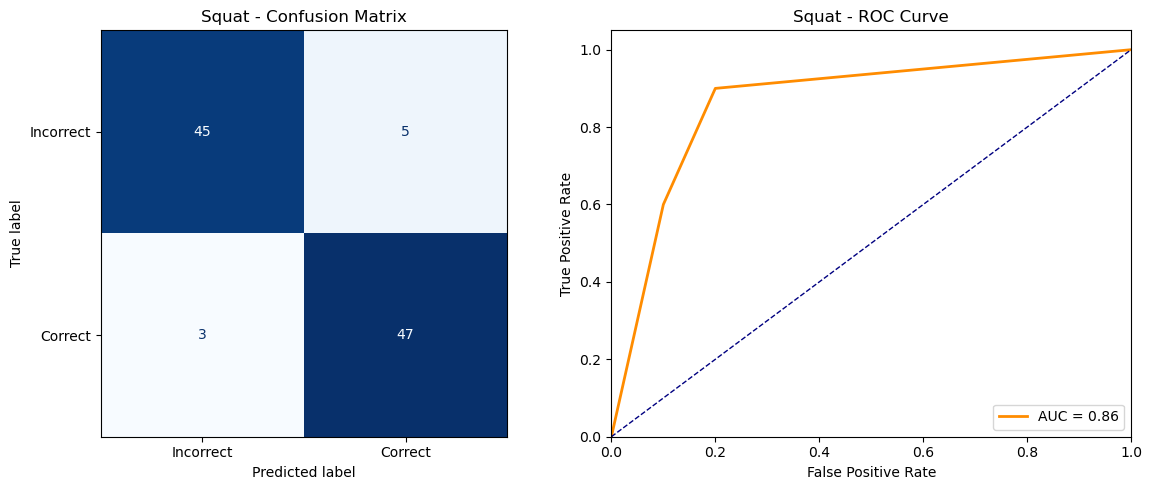

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, auc

# Squat Data
cm_squat = np.array([[45, 5], [3, 47]])
fpr_squat = np.array([0.0, 0.1, 0.2, 1.0])
tpr_squat = np.array([0.0, 0.6, 0.9, 1.0])
auc_squat = auc(fpr_squat, tpr_squat)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_squat, display_labels=["Incorrect", "Correct"])
disp.plot(ax=ax[0], cmap='Blues', colorbar=False, values_format='d')
ax[0].set_title("Squat - Confusion Matrix")

ax[1].plot(fpr_squat, tpr_squat, color='darkorange', lw=2, label=f"AUC = {auc_squat:.2f}")
ax[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title("Squat - ROC Curve")
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


NameError: name 'y_pred_prob' is not defined

In [ ]:
import cv2
import numpy as np
from collections import deque
import math

# Buffer to hold the last 30 frames of landmarks
sequence_length = 30
landmark_sequence = deque(maxlen=sequence_length)  # Keeps the latest 30 frames

# Squat counter variables
squat_counter = 0
squat_in_progress = False  # To track if a squat is currently being performed

def calculate_angle(a, b, c):
    """Calculate the angle between three points (a, b, c)."""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    ab = a - b
    cb = c - b
    
    cosine_angle = np.dot(ab, cb) / (np.linalg.norm(ab) * np.linalg.norm(cb))
    angle = np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))
    return angle

def real_time_posture_correction():
    global squat_counter, squat_in_progress
    
    cap = cv2.VideoCapture(0)  # Start the webcam
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)
        
        if results.pose_landmarks:
            # Extract landmarks from the frame
            landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
            landmark_sequence.append(landmarks)  # Add the frame's landmarks to the sequence
            
            # Draw landmarks on the frame
            for landmark in results.pose_landmarks.landmark:
                h, w, _ = frame.shape
                x = int(landmark.x * w)
                y = int(landmark.y * h)
                cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)  # Green color for landmarks
            
            # Ensure we have a full sequence to make a prediction
            if len(landmark_sequence) == sequence_length:
                input_data = np.expand_dims(np.array(landmark_sequence), axis=0)
                
                # Make a prediction
                prediction = model.predict(input_data)
                label = "Correct" if prediction > 0.5 else "Incorrect"
                
                # Display the prediction on the frame
                cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (0, 255, 0) if label == "Correct" else (0, 0, 255), 2)
            
            # Calculate knee angle for squat detection
            h, w, _ = frame.shape
            left_hip = (results.pose_landmarks.landmark[23].x * w, results.pose_landmarks.landmark[23].y * h)
            left_knee = (results.pose_landmarks.landmark[25].x * w, results.pose_landmarks.landmark[25].y * h)
            left_ankle = (results.pose_landmarks.landmark[27].x * w, results.pose_landmarks.landmark[27].y * h)
            
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            
            # Squat counting logic
            if knee_angle < 70:  # Squatting down threshold
                squat_in_progress = True
            elif knee_angle > 160 and squat_in_progress:  # Standing back up threshold
                squat_counter += 1
                squat_in_progress = False
            
            # Display the squat counter on the frame
            cv2.putText(frame, f"Squats: {squat_counter}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (255, 255, 255), 2)
        
        # Display the frame with annotations
        cv2.imshow("Posture Correction", frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Run real-time posture correction
real_time_posture_correction()


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Assuming you already have your test labels and predicted probabilities:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.4f}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Generate predicted classes
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Display the confusion matrix using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Incorrect", "Correct"])
disp.plot(cmap=plt.cm.Blues)

# Optional customization
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

